In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

from mlxtend.frequent_patterns import apriori, association_rules
# Đọc dữ liệu
data = pd.read_csv("HeartDiseaseTrain-Test.csv")

data.head()


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

,age,sex,chest_pain_type,resting_blood_pressure,cholestoral,fasting_blood_sugar,rest_ecg,Max_heart_rate,exercise_induced_angina,oldpeak,slope,vessels_colored_by_flourosopy,thalassemia,target
0,52,Male,Typical angina,125,212,Lower than 120 mg/ml,ST-T wave abnormality,168,No,1.0,Downsloping,Two,Reversable Defect,0
1,53,Male,Typical angina,140,203,Greater than 120 mg/ml,Normal,155,Yes,3.1,Upsloping,Zero,Reversable Defect,0
2,70,Male,Typical angina,145,174,Lower than 120 mg/ml,ST-T wave abnormality,125,Yes,2.6,Upsloping,Zero,Reversable Defect,0
3,61,Male,Typical angina,148,203,Lower than 120 mg/ml,ST-T wave abnormality,161,No,0.0,Downsloping,One,Reversable Defect,0
4,62,Female,Typical angina,138,294,Greater than 120 mg/ml,ST-T wave abnormality,106,No,1.9,Flat,Three,Fixed Defect,0


In [3]:
data.info()
data.isnull().sum()
X = data.drop(columns=['target'])
y = data['target']


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1025 entries, 0 to 1024
Data columns (total 14 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   age                            1025 non-null   int64  
 1   sex                            1025 non-null   object 
 2   chest_pain_type                1025 non-null   object 
 3   resting_blood_pressure         1025 non-null   int64  
 4   cholestoral                    1025 non-null   int64  
 5   fasting_blood_sugar            1025 non-null   object 
 6   rest_ecg                       1025 non-null   object 
 7   Max_heart_rate                 1025 non-null   int64  
 8   exercise_induced_angina        1025 non-null   object 
 9   oldpeak                        1025 non-null   float64
 10  slope                          1025 non-null   object 
 11  vessels_colored_by_flourosopy  1025 non-null   object 
 12  thalassemia                    1025 non-null   o

In [4]:
data_apriori = data.copy()

# Chia mỗi cột số thành 3 khoảng
for col in data_apriori.columns:
    if data_apriori[col].dtype != 'object':
        data_apriori[col] = pd.qcut(
            data_apriori[col],
            q=3,
            duplicates='drop'
        )
data_encoded = pd.get_dummies(data_apriori)
data_encoded.head()
frequent_itemsets = apriori(
    data_encoded,
    min_support=0.1,
    use_colnames=True
)
frequent_itemsets.sort_values(by='support', ascending=False).head(10)


,support,itemsets
33,1.000000,"(target_(-0.001, 1.0])"
305,0.850732,"(target_(-0.001, 1.0], fasting_blood_sugar_Low..."
15,0.850732,(fasting_blood_sugar_Lower than 120 mg/ml)
144,0.695610,"(sex_Male, target_(-0.001, 1.0])"
4,0.695610,(sex_Male)
370,0.663415,"(target_(-0.001, 1.0], exercise_induced_angina..."
21,0.663415,(exercise_induced_angina_No)
733,0.587317,"(sex_Male, target_(-0.001, 1.0], fasting_blood..."
127,0.587317,"(sex_Male, fasting_blood_sugar_Lower than 120 ..."
1212,0.572683,"(target_(-0.001, 1.0], fasting_blood_sugar_Low..."


In [5]:
rules = association_rules(
    frequent_itemsets,
    metric="confidence",
    min_threshold=0.6
)
rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']] \
    .sort_values(by='lift', ascending=False).head(10)


,antecedents,consequents,support,confidence,lift
12530,"(sex_Male, chest_pain_type_Typical angina, old...","(target_(-0.001, 1.0], exercise_induced_angina...",0.103415,0.658385,3.408307
12520,"(sex_Male, chest_pain_type_Typical angina, tar...","(exercise_induced_angina_Yes, Max_heart_rate_(...",0.103415,0.658385,3.408307
7587,"(sex_Male, chest_pain_type_Typical angina, old...","(exercise_induced_angina_Yes, Max_heart_rate_(...",0.103415,0.658385,3.408307
14698,"(chest_pain_type_Typical angina, sex_Male, tar...","(exercise_induced_angina_Yes, Max_heart_rate_(...",0.110244,0.631285,3.268015
14717,"(sex_Male, chest_pain_type_Typical angina, fas...","(target_(-0.001, 1.0], exercise_induced_angina...",0.110244,0.631285,3.268015
12312,"(sex_Male, chest_pain_type_Typical angina, fas...","(exercise_induced_angina_Yes, Max_heart_rate_(...",0.110244,0.631285,3.268015
12315,"(exercise_induced_angina_Yes, Max_heart_rate_(...","(sex_Male, chest_pain_type_Typical angina, slo...",0.110244,0.645714,3.260380
14720,"(exercise_induced_angina_Yes, Max_heart_rate_(...","(sex_Male, chest_pain_type_Typical angina, tar...",0.110244,0.645714,3.260380
14706,"(target_(-0.001, 1.0], exercise_induced_angina...","(sex_Male, chest_pain_type_Typical angina, slo...",0.110244,0.645714,3.260380
7590,"(oldpeak_(1.4, 6.2], exercise_induced_angina_Yes)","(sex_Male, chest_pain_type_Typical angina, Max...",0.103415,0.612717,3.140173


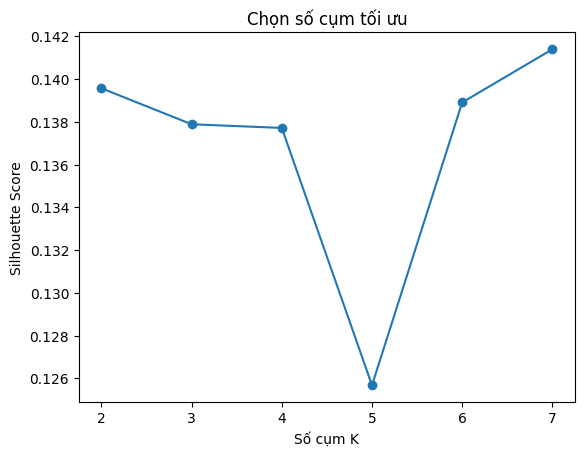

In [7]:
silhouette_scores = []

# Identify categorical and numerical columns in X
categorical_cols = X.select_dtypes(include=['object']).columns
numerical_cols = X.select_dtypes(exclude=['object']).columns

# One-hot encode categorical columns
X_encoded = pd.get_dummies(X, columns=categorical_cols, drop_first=True)

# Scale all features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_encoded)

K_range = range(2, 8)
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X_scaled)
    score = silhouette_score(X_scaled, labels)
    silhouette_scores.append(score)
plt.figure()
plt.plot(K_range, silhouette_scores, marker='o')
plt.xlabel("Số cụm K")
plt.ylabel("Silhouette Score")
plt.title("Chọn số cụm tối ưu")
plt.show()

In [8]:
k_optimal = K_range[np.argmax(silhouette_scores)]

kmeans = KMeans(n_clusters=k_optimal, random_state=42)
clusters = kmeans.fit_predict(X_scaled)

data['Cluster'] = clusters
data.head()


,age,sex,chest_pain_type,resting_blood_pressure,cholestoral,fasting_blood_sugar,rest_ecg,Max_heart_rate,exercise_induced_angina,oldpeak,slope,vessels_colored_by_flourosopy,thalassemia,target,Cluster
0,52,Male,Typical angina,125,212,Lower than 120 mg/ml,ST-T wave abnormality,168,No,1.0,Downsloping,Two,Reversable Defect,0,5
1,53,Male,Typical angina,140,203,Greater than 120 mg/ml,Normal,155,Yes,3.1,Upsloping,Zero,Reversable Defect,0,0
2,70,Male,Typical angina,145,174,Lower than 120 mg/ml,ST-T wave abnormality,125,Yes,2.6,Upsloping,Zero,Reversable Defect,0,0
3,61,Male,Typical angina,148,203,Lower than 120 mg/ml,ST-T wave abnormality,161,No,0.0,Downsloping,One,Reversable Defect,0,3
4,62,Female,Typical angina,138,294,Greater than 120 mg/ml,ST-T wave abnormality,106,No,1.9,Flat,Three,Fixed Defect,0,2


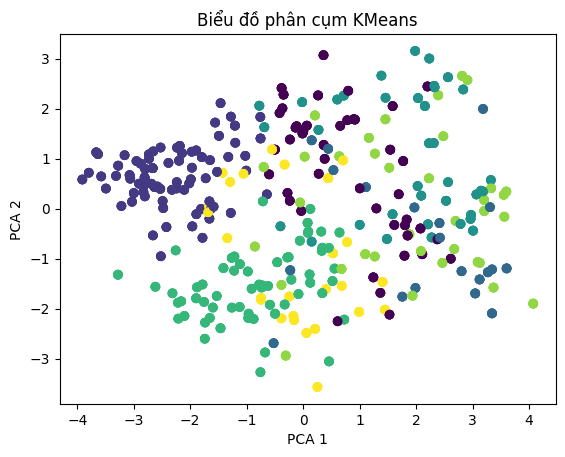

In [9]:
final_score = silhouette_score(X_scaled, clusters)
final_score
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
plt.figure()
plt.scatter(X_pca[:,0], X_pca[:,1], c=clusters)
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.title("Biểu đồ phân cụm KMeans")
plt.show()


## Phân tích đặc điểm số

### Subtask:
Tính toán các thống kê mô tả (trung bình, trung vị, độ lệch chuẩn) cho các thuộc tính số trong mỗi cụm.


In [10]:
numerical_cols = ['age', 'resting_blood_pressure', 'cholestoral', 'Max_heart_rate', 'oldpeak']

cluster_descriptive_stats = data.groupby('Cluster')[numerical_cols].agg(['mean', 'median', 'std'])

print(cluster_descriptive_stats)

               age                  resting_blood_pressure                    \
              mean median       std                   mean median        std   
Cluster                                                                        
0        54.878205   57.0  9.459825             137.397436  135.0  19.454058   
1        48.110236   47.0  7.822364             126.578740  124.0  14.650058   
2        59.927536   62.0  7.961892             136.971014  130.0  16.498637   
3        57.268657   57.0  5.506202             126.253731  125.0  15.993742   
4        52.929293   53.0  9.460849             130.959596  130.0  15.396564   
5        59.726562   60.0  6.254088             136.117188  134.0  20.354968   
6        59.069767   57.0  7.481413             134.825581  130.0  18.257113   

        cholestoral                   Max_heart_rate                    \
               mean median        std           mean median        std   
Cluster                                            

## Phân tích đặc điểm phân loại

### Subtask:
Tính toán và hiển thị phân phối tần suất (số lượng hoặc tỷ lệ phần trăm) của các giá trị cho tất cả các thuộc tính phân loại (`sex`, `chest_pain_type`, `fasting_blood_sugar`, `rest_ecg`, `exercise_induced_angina`, `slope`, `vessels_colored_by_flourosopy`, `thalassemia`) cho mỗi cụm.

## Phân tích đặc điểm phân loại

### Subtask:
Tính toán và hiển thị phân phối tần suất (số lượng hoặc tỷ lệ phần trăm) của các giá trị cho tất cả các thuộc tính phân loại (`sex`, `chest_pain_type`, `fasting_blood_sugar`, `rest_ecg`, `exercise_induced_angina`, `slope`, `vessels_colored_by_flourosopy`, `thalassemia`) cho mỗi cụm.

In [11]:
categorical_cols = ['sex', 'chest_pain_type', 'fasting_blood_sugar', 'rest_ecg', 'exercise_induced_angina', 'slope', 'vessels_colored_by_flourosopy', 'thalassemia']

for cluster_id in sorted(data['Cluster'].unique()):
    print(f"\n--- Cluster {cluster_id} ---")
    cluster_data = data[data['Cluster'] == cluster_id]
    for col in categorical_cols:
        print(f"\n{col.replace('_', ' ').title()}:")
        print(cluster_data[col].value_counts(normalize=True).mul(100).round(2).astype(str) + '%')



--- Cluster 0 ---

Sex:
sex
Male      71.79%
Female    28.21%
Name: proportion, dtype: object

Chest Pain Type:
chest_pain_type
Typical angina      85.26%
Asymptomatic         8.33%
Non-anginal pain     6.41%
Name: proportion, dtype: object

Fasting Blood Sugar:
fasting_blood_sugar
Lower than 120 mg/ml      82.05%
Greater than 120 mg/ml    17.95%
Name: proportion, dtype: object

Rest Ecg:
rest_ecg
ST-T wave abnormality           60.26%
Normal                          37.18%
Left ventricular hypertrophy     2.56%
Name: proportion, dtype: object

Exercise Induced Angina:
exercise_induced_angina
Yes    73.72%
No     26.28%
Name: proportion, dtype: object

Slope:
slope
Flat           62.82%
Upsloping      20.51%
Downsloping    16.67%
Name: proportion, dtype: object

Vessels Colored By Flourosopy:
vessels_colored_by_flourosopy
Zero    98.08%
Four     1.92%
Name: proportion, dtype: object

Thalassemia:
thalassemia
Reversable Defect    58.33%
Fixed Defect         25.64%
Normal               

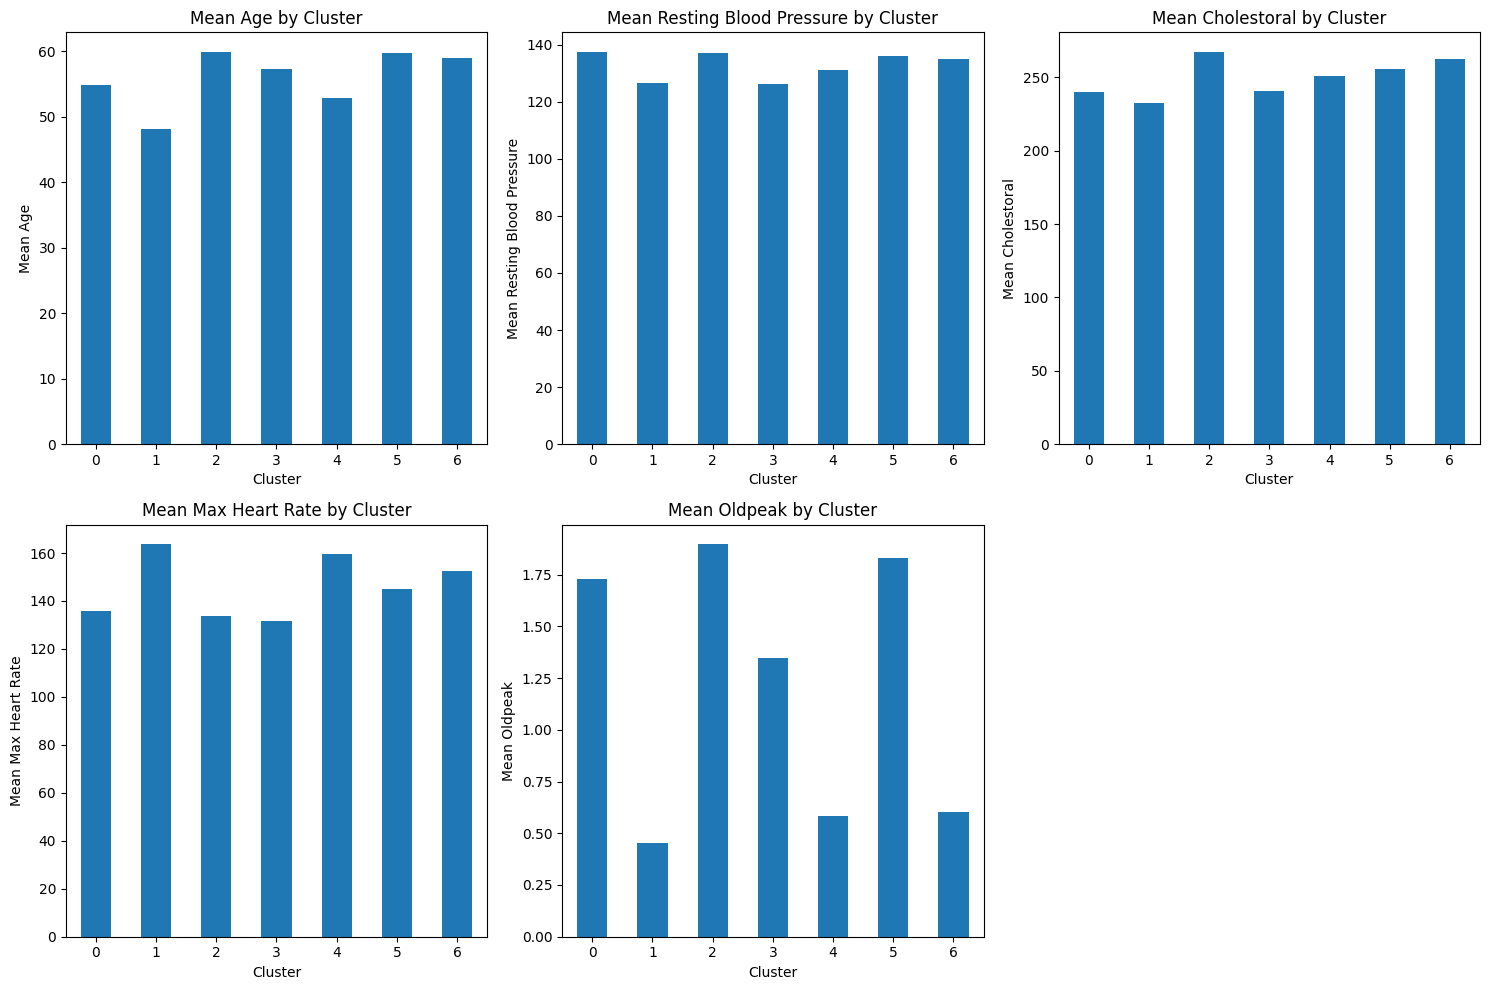

In [12]:
numerical_cols = ['age', 'resting_blood_pressure', 'cholestoral', 'Max_heart_rate', 'oldpeak']

plt.figure(figsize=(15, 10))
for i, col in enumerate(numerical_cols):
    plt.subplot(2, 3, i + 1)  # Adjust subplot grid as needed
    cluster_descriptive_stats[col]['mean'].plot(kind='bar')
    plt.title(f'Mean {col.replace("_", " ").title()} by Cluster')
    plt.xlabel('Cluster')
    plt.ylabel(f'Mean {col.replace("_", " ").title()}')
    plt.xticks(rotation=0)
plt.tight_layout()
plt.show()